# Model Training, Evaluation, and Interpretation

This notebook performs the following steps: 

1) Load prepared data generated by load_data.ipynb
2) Split data into train and test sets
3) Train XGBoost model on train set and evaluate model on test set
4) Save model parameters for use later 
5) Use SHAP values to interpret the trained model

In [2]:
import torch
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import shap
from datetime import datetime

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, log_loss, f1_score

root_dir = os.getcwd()

## Load Data and Split into Train and Test Sets

**Note: Replace filenames with your specific tackle_sequence, test_tracking_data, and train_tracking_data filenames.**

In [3]:
# Load data from the save/ directory
print("INFO: LOADING TACKLE SEQUENCES AND TRACKING DATA")
ts_lists = pickle.load(open(os.path.join(root_dir, "save/tackle_sequences_01072024-2324.pkl"), "rb"))
df_tracking_test = pickle.load(open(os.path.join(root_dir, "save/test_tracking_data_01072024-2324.pkl"), "rb"))
df_tracking_train = pickle.load(open(os.path.join(root_dir, "save/train_tracking_data_01072024-2324.pkl"), "rb"))
tackle_sequences_train = ts_lists["train"]
tackle_sequences_test = ts_lists["test"]

INFO: LOADING TACKLE SEQUENCES AND TRACKING DATA


In [4]:
# Split into test, val, and train datasets
X = torch.stack([ts.input_tensor[0, :] for ts in tackle_sequences_train]).numpy()
y = np.array([ts.target for ts in tackle_sequences_train])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1234)

X_test = np.array([ts.input_tensor[0, :] for ts in tackle_sequences_test])
y_test = np.array([ts.target for ts in tackle_sequences_test])

print(f"Train dataset size = {len(y_train)} | Val dataset size = {len(y_val)} | Test dataset size = {len(y_test)}")

Train dataset size = 8624 | Val dataset size = 959 | Test dataset size = 1016


## Train and Evaluate Model

In [4]:
# optimize hyperparameters with a random search 

# Define hyperparameters to search 
scale_pos_weight = sum(y == 0)/ sum(y == 1)
param_dict = {"max_depth": np.arange(3,10),
              "eta": np.logspace(-3, 0, 4),
              "n_estimators": np.arange(50, 300, 50), 
            }

# create model object
tree = xgb.XGBClassifier(objective="binary:logistic", reg_lambda=150, scale_pos_weight=scale_pos_weight)

# create random search object
clf = RandomizedSearchCV(tree, param_dict, n_iter=100, cv=5, verbose=2, random_state=1234, scoring=['neg_log_loss', 'f1', 'roc_auc'], refit='neg_log_loss')

# fit the model
clf.fit(X_train, y_train.tolist())

# print the best parameters and scores
cv_results = clf.cv_results_
print(f"Best Parameters: {clf.best_params_}")
print(f"Best F1 and AUC Score: {clf.best_score_}")

df_cv_results = pd.DataFrame(cv_results)
df_cv_results.sort_values(by=["rank_test_neg_log_loss", "rank_test_f1", "rank_test_roc_auc"], ascending=[True, True, True], inplace=True)
print(f"Min Neg Log Loss = {df_cv_results['mean_test_neg_log_loss'].max():.3f} | Max F1 Score = {df_cv_results['mean_test_f1'].max():.3f} | Max AUC Score = {df_cv_results['mean_test_roc_auc'].max():.3f}")
df_cv_results[["params", "mean_test_neg_log_loss", "rank_test_neg_log_loss", "mean_test_f1", "rank_test_f1", "mean_test_roc_auc", "rank_test_roc_auc"]].head()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...........eta=0.001, max_depth=4, n_estimators=100; total time=   0.8s
[CV] END ...........eta=0.001, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ...........eta=0.001, max_depth=4, n_estimators=100; total time=   0.6s
[CV] END ...........eta=0.001, max_depth=4, n_estimators=100; total time=   0.7s
[CV] END ...........eta=0.001, max_depth=4, n_estimators=100; total time=   0.9s
[CV] END .............eta=0.1, max_depth=8, n_estimators=100; total time=   1.5s
[CV] END .............eta=0.1, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END .............eta=0.1, max_depth=8, n_estimators=100; total time=   1.2s
[CV] END .............eta=0.1, max_depth=8, n_estimators=100; total time=   1.6s
[CV] END .............eta=0.1, max_depth=8, n_estimators=100; total time=   1.4s
[CV] END .............eta=0.1, max_depth=7, n_estimators=100; total time=   1.1s
[CV] END .............eta=0.1, max_depth=7, n_

,params,mean_test_neg_log_loss,rank_test_neg_log_loss,mean_test_f1,rank_test_f1,mean_test_roc_auc,rank_test_roc_auc
39,"{'n_estimators': 250, 'max_depth': 8, 'eta': 1.0}",-0.244717,1,0.939355,1,0.945094,26
82,"{'n_estimators': 200, 'max_depth': 8, 'eta': 1.0}",-0.245430,2,0.938748,2,0.945687,23
94,"{'n_estimators': 200, 'max_depth': 7, 'eta': 1.0}",-0.247228,3,0.937565,3,0.945983,17
12,"{'n_estimators': 150, 'max_depth': 9, 'eta': 1.0}",-0.248007,4,0.935467,6,0.946112,14
55,"{'n_estimators': 150, 'max_depth': 8, 'eta': 1.0}",-0.248048,5,0.936418,4,0.946474,9


[0]	validation_0-logloss:0.66627	validation_0-log_loss:0.66627	validation_1-logloss:0.66492	validation_1-log_loss:0.66492
[1]	validation_0-logloss:0.64137	validation_0-log_loss:0.64137	validation_1-logloss:0.63882	validation_1-log_loss:0.63882
[2]	validation_0-logloss:0.62010	validation_0-log_loss:0.62010	validation_1-logloss:0.61621	validation_1-log_loss:0.61621
[3]	validation_0-logloss:0.60073	validation_0-log_loss:0.60073	validation_1-logloss:0.59588	validation_1-log_loss:0.59588
[4]	validation_0-logloss:0.58372	validation_0-log_loss:0.58372	validation_1-logloss:0.57768	validation_1-log_loss:0.57768
[5]	validation_0-logloss:0.56880	validation_0-log_loss:0.56880	validation_1-logloss:0.56207	validation_1-log_loss:0.56207
[6]	validation_0-logloss:0.55567	validation_0-log_loss:0.55566	validation_1-logloss:0.54809	validation_1-log_loss:0.54809
[7]	validation_0-logloss:0.54350	validation_0-log_loss:0.54350	validation_1-logloss:0.53508	validation_1-log_loss:0.53508
[8]	validation_0-logloss

[10:53:43] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


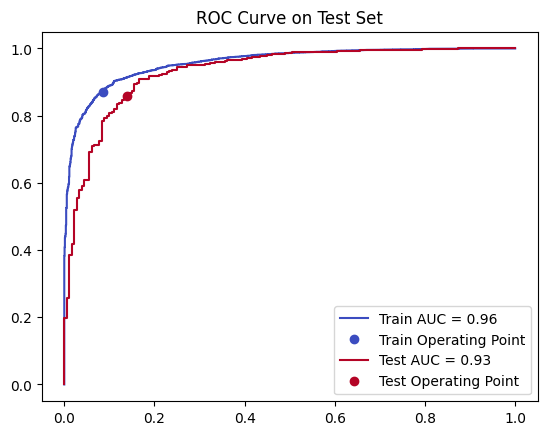

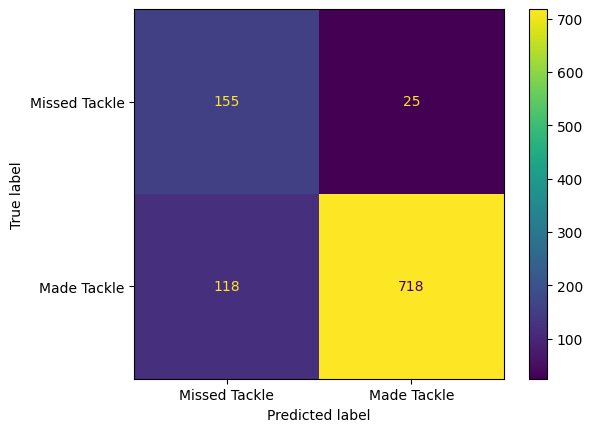

In [5]:
# Train with selected set of hyperparameters 
params_opt = {"objective": "binary:logistic", "max_depth": 7, "eta": 0.1, "n_estimators": 150, "reg_lambda": 150, "subsample": 0.75, "colsample_bytree": 1, "colsample_bylevel": 1,
              "scale_pos_weight": sum(y_train == 0)/ sum(y_train == 1), 
              "eval_metric": log_loss, "early_stopping_rounds":20, "verbosity": 2
              }
clf = XGBClassifier(**params_opt)

# fit the model and evaluate it on the val set 
clf.fit(X_train, y_train, eval_set=[(X_val, y_val), (X_train, y_train)], verbose=True)

# Save the model to load later 
current_datetime = datetime.now().strftime("%m%d%Y-%H%M")
clf.save_model(os.path.join(root_dir, f'save/XGBoost_{current_datetime}.model'))

# eval XGBoost on train set
thres = 0.5
probs_xgb = clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, probs_xgb[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=(0.2298057, 0.29871797, 0.75368315), label=f"Train AUC = {roc_auc:.2f}")
tp_xgb = ((probs_xgb[:, 1] >= thres) & (y_train == 1)).sum().item()
fp_xgb = ((probs_xgb[:, 1] >= thres) & (y_train == 0)).sum().item()
fn_xgb = ((probs_xgb[:, 1] < thres) & (y_train == 1)).sum().item()
tn_xgb = ((probs_xgb[:, 1] < thres) & (y_train == 0)).sum().item()
print(f"False Positive Rate on Train Set = {fp_xgb/(fp_xgb + tn_xgb):.2f}")
print(f"False Negative Rate on Train Set = {fn_xgb/(fn_xgb + tp_xgb):.2f}")
plt.plot([fp_xgb/(fp_xgb+tn_xgb)], [tp_xgb/(tp_xgb+fn_xgb)], 'o', color=(0.2298057, 0.29871797, 0.75368315), label="Train Operating Point")
plt.title("ROC Curve on Train Set")
plt.legend()

# eval XGBoost on test set
probs_xgb = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs_xgb[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=(0.70567316, 0.01555616, 0.15023281), label=f"Test AUC = {roc_auc:.2f}")
tp_xgb = ((probs_xgb[:, 1] >= thres) & (y_test == 1)).sum().item()
fp_xgb = ((probs_xgb[:, 1] >= thres) & (y_test == 0)).sum().item()
fn_xgb = ((probs_xgb[:, 1] < thres) & (y_test == 1)).sum().item()
tn_xgb = ((probs_xgb[:, 1] < thres) & (y_test == 0)).sum().item()
print(f"False Positive Rate on Test Set = {fp_xgb/(fp_xgb + tn_xgb):.2f}")
print(f"False Negative Rate on Test Set = {fn_xgb/(fn_xgb + tp_xgb):.2f}")
plt.plot([fp_xgb/(fp_xgb+tn_xgb)], [tp_xgb/(tp_xgb+fn_xgb)], 'o', color=(0.70567316, 0.01555616, 0.15023281), label="Test Operating Point")
plt.title("ROC Curve on Test Set")
plt.legend()

ConfusionMatrixDisplay(
    confusion_matrix=np.array([[tn_xgb, fp_xgb], [fn_xgb, tp_xgb]]),
    display_labels=["Missed Tackle", "Made Tackle"],
).plot()

# Classification Report
print(" ============== CLASSIFICATION REPORT (Test Set) ==============")
print("             precision    recall  f1-score   support")
print(f"Made Tackle       {tp_xgb/(tp_xgb+fp_xgb):.2f}      {tp_xgb/(tp_xgb+fn_xgb):.2f}      {f1_score(y_test, probs_xgb[:, 1] >= thres):.2f}      {tp_xgb+fn_xgb}")
print(f"Missed Tackle     {tn_xgb/(tn_xgb+fn_xgb):.2f}      {tn_xgb/(tn_xgb+fp_xgb):.2f}      {f1_score(y_test, probs_xgb[:, 1] >= thres, pos_label=0):.2f}      {tn_xgb+fp_xgb}")


# Model Interpretation

In this section, SHAP (SHapley Additive exPlanations) values are used to interpret how the XGBoost model is using the features to predict the outcome. SHAP values calculate the contribution of each feature by computing the difference between the predicted output using all features and the predicted output using only a subset of features. The SHAP value of each feature is the sum of the differences, weighted by the number of subsets that contains the specific feature 

See Lundberg et al, 2017, https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf for more details. 

[21:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


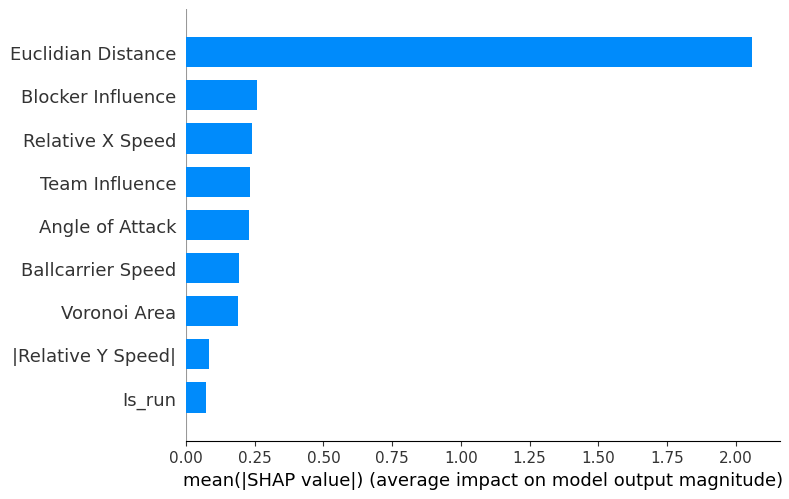

In [7]:
# plot global feature importance
feature_names = ["Ballcarrier Speed", "Relative X Speed", "|Relative Y Speed|", "Euclidian Distance", "Angle of Attack", "Voronoi Area", "Team Influence", "Blocker Influence", "Is_run"]

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names)

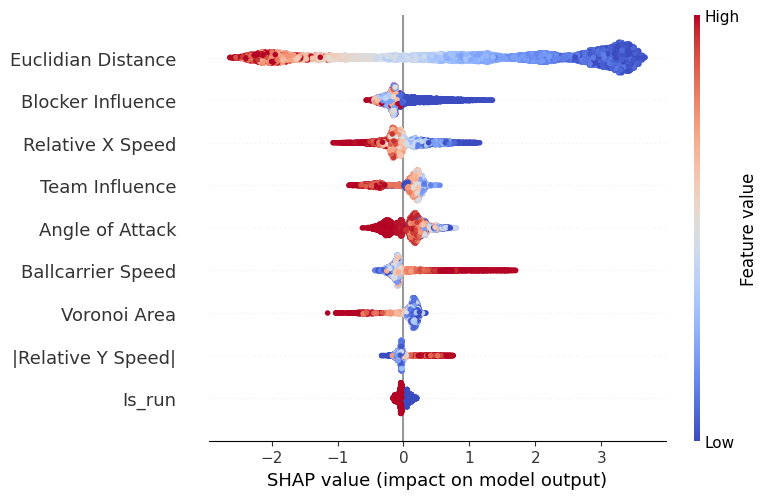

In [8]:
# Plot SHAP beeswarm plot to visualize feature importance in more detail 

shap.summary_plot(shap_values, X, feature_names=feature_names, cmap="coolwarm")

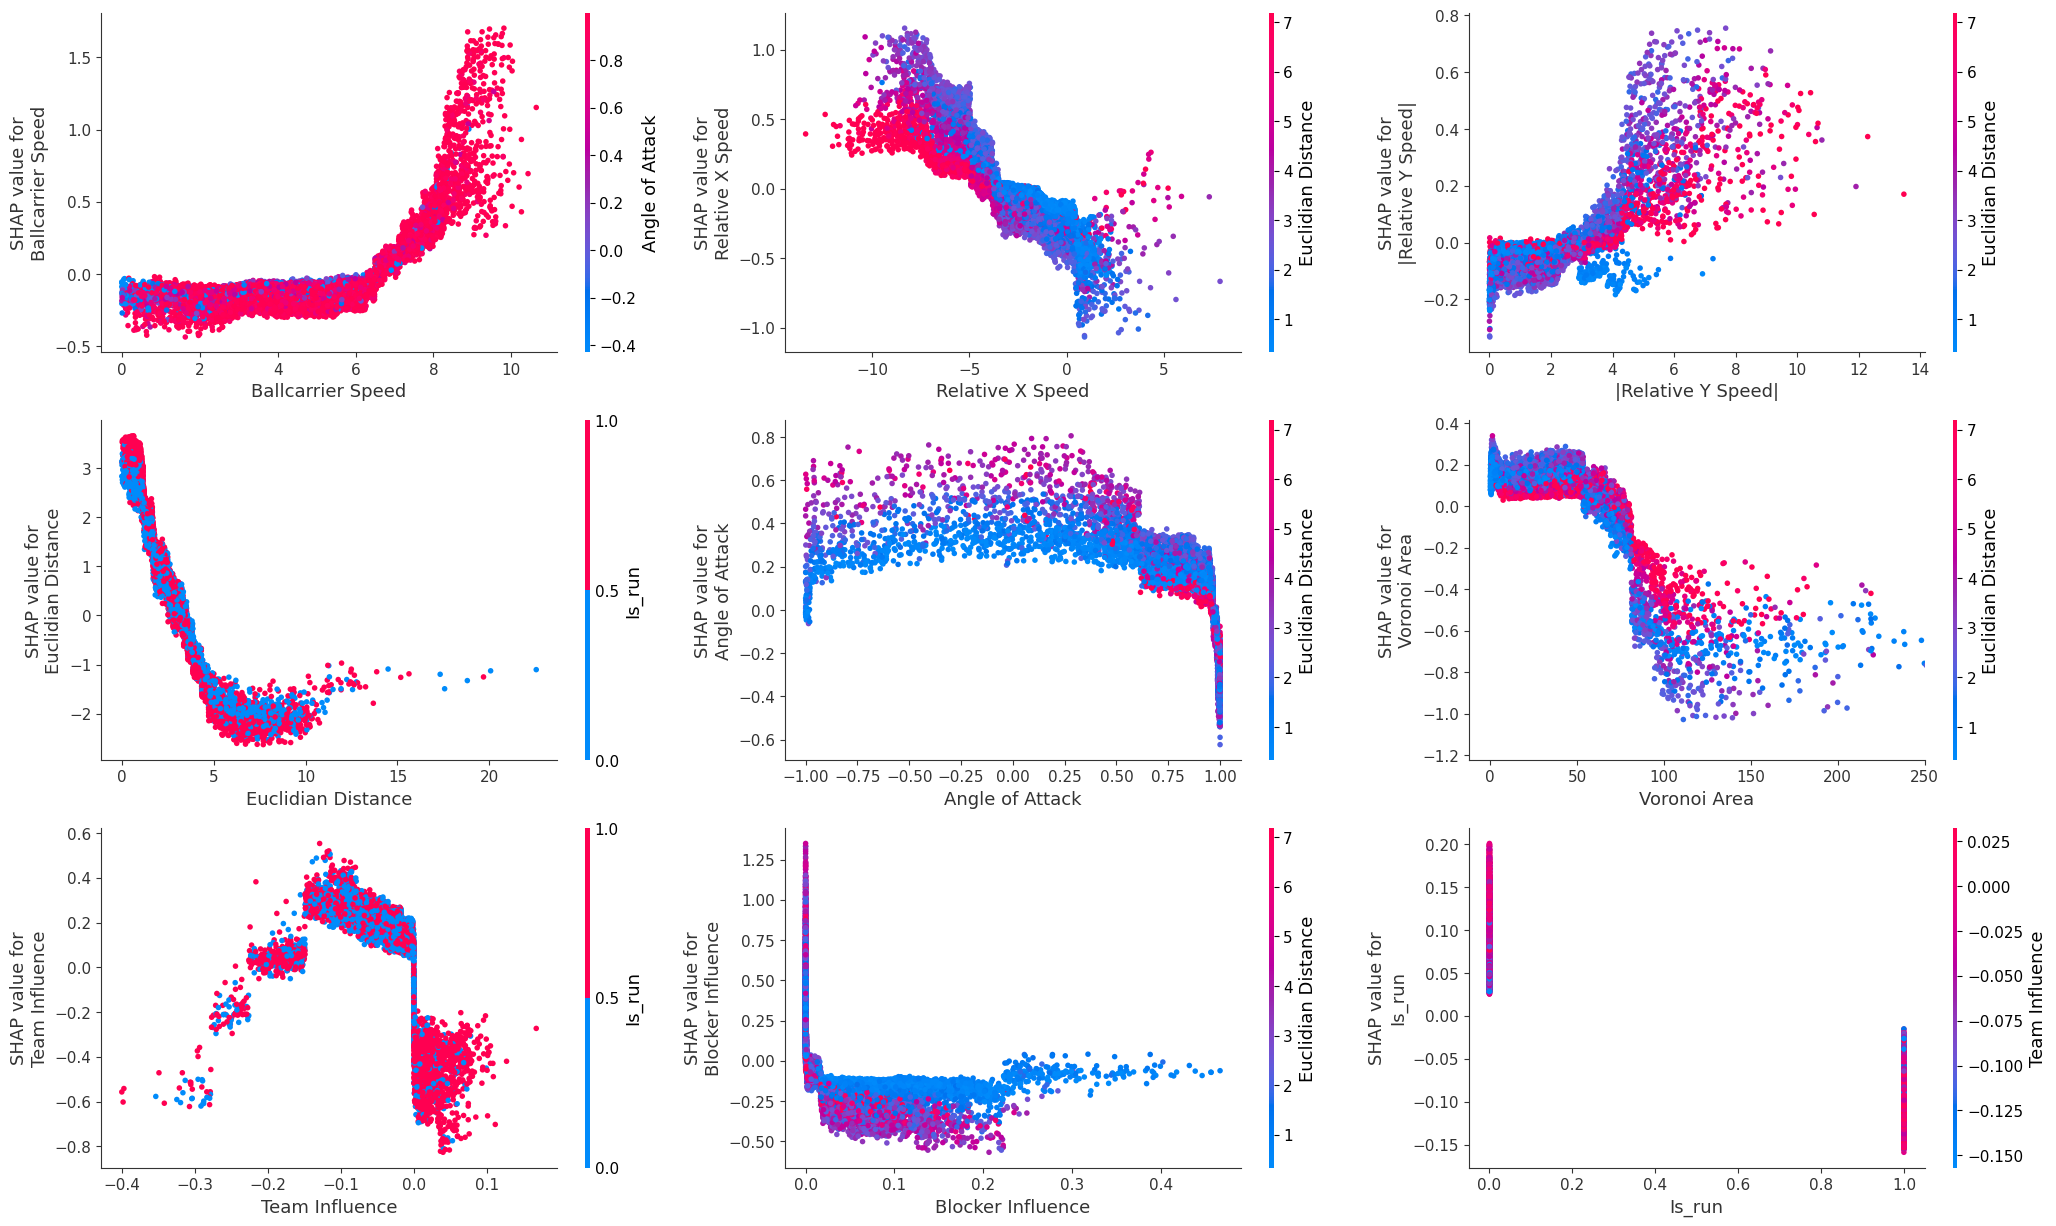

In [9]:
# Plot pair-wise interactions between features 
fig, axs = plt.subplots(3,3, figsize=(25,15))
for i, name in enumerate(feature_names):
    row = i // 3
    col = i % 3
    if name == "Team Influence": 
        shap.dependence_plot(name, shap_values, X, display_features=X, feature_names=feature_names, interaction_index="Is_run", ax=axs[row][col], show=False)
    elif name == "Voronoi Area": 
        shap.dependence_plot(name, shap_values, X, display_features=X, feature_names=feature_names, xmax=250, ax=axs[row][col], show=False)
    elif name == "Is_run": 
        shap.dependence_plot(name, shap_values, X, display_features=X, feature_names=feature_names, interaction_index="Team Influence", ax=axs[row][col], show=False)
    elif name == "Ballcarrier Speed":
        shap.dependence_plot(name, shap_values, X, display_features=X, feature_names=feature_names, interaction_index="Angle of Attack", ax=axs[row][col], show=False)
    elif name == "Blocker Influence":
        shap.dependence_plot(name, shap_values, X, display_features=X, feature_names=feature_names, interaction_index="Euclidian Distance", ax=axs[row][col], show=False)
    else:
        shap.dependence_plot(name, shap_values, X, display_features=X, feature_names=feature_names, ax=axs[row][col], show=False)

GameId = 2022110603, PlayId = 2761, FrameId = 24, ballcarrierId = 53541, tacklerId = 42485, target = 1
Feature Values: [ 7.43        2.7048502   4.3762856   1.8435835   0.90958947 16.755932
 -0.02224153  0.02415106  0.        ]
Predicted result = [[0.3238203 0.6761797]]


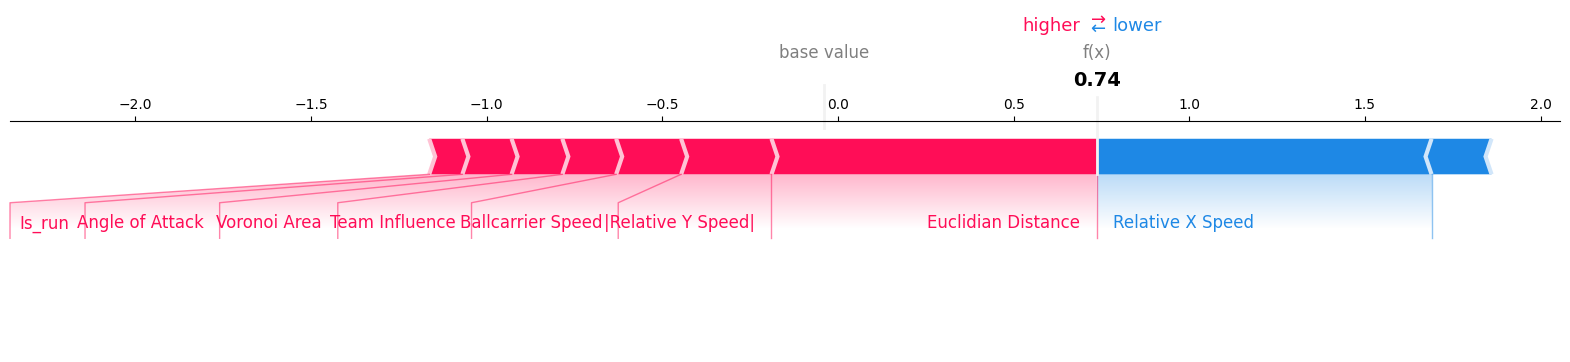

GameId = 2022110603, PlayId = 2761, FrameId = 12, ballcarrierId = 53541, tacklerId = 47804, target = 0
Feature Values: [ 7.9400001e+00 -2.8935955e+00  2.2745504e+00  2.3621178e+00
  9.8806071e-01  4.2925957e+01 -3.7463866e-03  9.0239797e-04
  0.0000000e+00]
Predicted result = [[0.19997102 0.800029  ]]


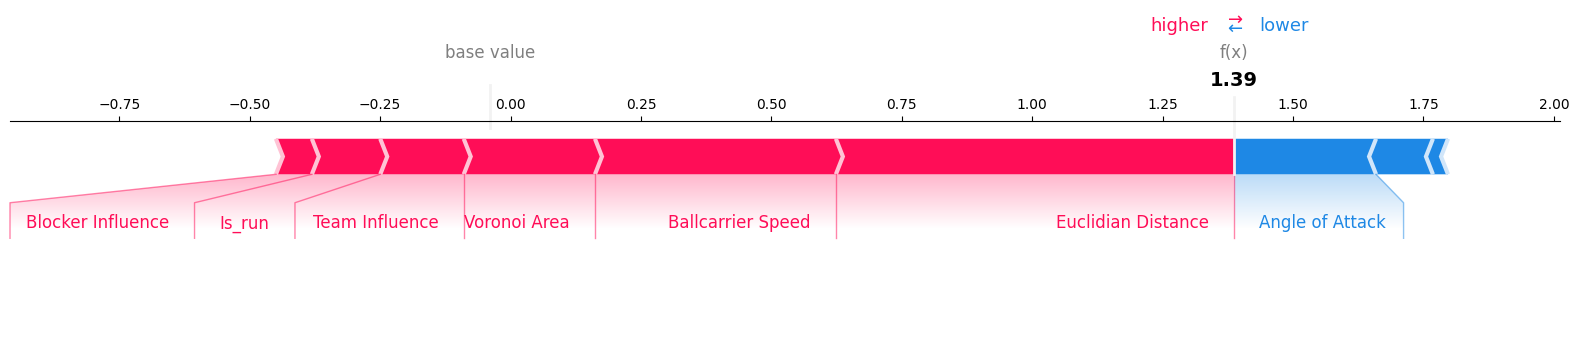

In [10]:
# Measure SHAP values on specific instances
gameplayId = [(2022110603, 2761)]       # get the index of the tackle sequence we want to look at. This looks are missed and made tackles on the play. 

for gameId, playId in gameplayId: 
    # find tackle_sequence with this gameId and playId
    for i, ts in enumerate(tackle_sequences_test): 
        if ts.gameId == gameId and ts.playId == playId: 

            print(f"GameId = {ts.gameId}, PlayId = {ts.playId}, FrameId = {ts.start_frameId}, ballcarrierId = {ts.ballCarrierId}, tacklerId = {ts.tacklerId}, target = {ts.target}")

            # get the feature values for this tackle sequence
            Xi = ts.input_tensor[0, :].numpy()
            print(f"Feature Values: {Xi}")

            # make a prediction
            y_pred = clf.predict_proba(Xi.reshape(1, -1))
            print(f"Predicted result = {y_pred}")

            # generate SHAP values for the test set 
            shap_value = explainer.shap_values(Xi.reshape(1, -1))

            # plot the SHAP force plot for this tackle
            shap.force_plot(explainer.expected_value, shap_value, feature_names=feature_names, matplotlib=True)